## IBM Machine Learning Course Lab 2 - Multiple Linear Regression

This is my own attempt at Lab 2 of 'Machine Learning with Python' by IBM on Coursera. It includes my own insight when solving problems. The method of analysis presented here is far more rigorous than that required by the course.

In [3]:
""" importing necessary packages """
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pylab as pl
%matplotlib inline


In [4]:
""" getting data and importing it into a pd dataframe"""

#obtain data (requires wget, $ brew install wget)
!wget -O FuelData.csv \
https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/FuelConsumptionCo2.csv

df = pd.read_csv('FuelData.csv')
df.head() #check data uploaded

--2020-07-23 13:35:07--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/FuelConsumptionCo2.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72629 (71K) [text/csv]
Saving to: ‘FuelData.csv’

FuelData.csv        100%[===================>]  70.93K   131KB/s    in 0.5s    

2020-07-23 13:35:10 (131 KB/s) - ‘FuelData.csv’ saved [72629/72629]



,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2014,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,2014,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,2014,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,2014,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,2014,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


## Data exploration

<p>From the data exploration done in Lab 1, it was found that a number of different factors affect our CO2 emissions (this is our <i>target</i>)</p> These predictor variables are: # of cylinders, engine size, and the combined fuel consumption.

In [5]:
df_targ = df[['CO2EMISSIONS']]
df_pred = df[['FUELCONSUMPTION_CITY','FUELCONSUMPTION_HWY','FUELCONSUMPTION_COMB','ENGINESIZE','CYLINDERS']]
#note that the fuel combustion for city and highway are also being considered as predictors


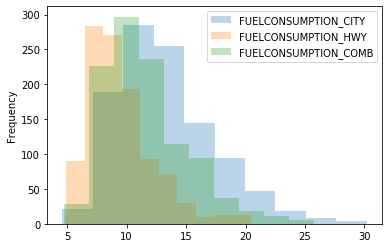

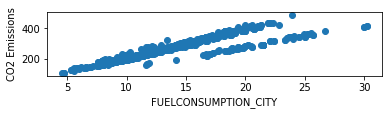

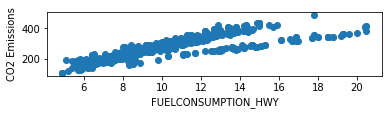

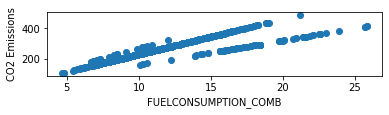

' Notes: all 3 are positively skewed, we might wanna apply a transformation to fix this.\nWe can see from the scatter plot that, all 3 graphs have more points on the steeper line. This may be an issue\nof the dataset, or it might be that the dataset is a representation of typical car engine structure.\nThe fact that there are very clear splits suggests that a third dimension is missing, i.e. there must be\nsome physical limitation (or maybe a standard procedure) which causes there to be 2 very clear patterns.\n(my thought is that it has something to do with cylinder size - cars come in 4, 6 or 8 cylinders, and my \nguess is that the number of cylinders and size are correlated such that they cause this split to occur?)\nWould be interesting to explore this further\n'

In [6]:
""" we'd like to explore the differences between the fuel consumptions """

fuel_cons = ['FUELCONSUMPTION_CITY','FUELCONSUMPTION_HWY','FUELCONSUMPTION_COMB']
for cons_type in fuel_cons:
    df_pred[cons_type].plot(kind = 'hist', alpha = 0.3)
plt.legend(labels = fuel_cons, loc = 'upper right')
plt.show()


i = 1;
for cons_type in fuel_cons:
    plt.subplot(3,1,i)
    i+=1
    plt.scatter(df_pred[cons_type],df_targ)
    plt.xlabel(cons_type)
    plt.ylabel('CO2 Emissions')
    plt.show()


                            
""" Notes: all 3 are positively skewed, we might wanna apply a transformation to fix this.
We can see from the scatter plot that, all 3 graphs have more points on the steeper line. This may be an issue
of the dataset, or it might be that the dataset is a representation of typical car engine structure.
The fact that there are very clear splits suggests that a third dimension is missing, i.e. there must be
some physical limitation (or maybe a standard procedure) which causes there to be 2 very clear patterns.
(my thought is that it has something to do with cylinder size - cars come in 4, 6 or 8 cylinders, and my 
guess is that the number of cylinders and size are correlated such that they cause this split to occur?)
Would be interesting to explore this further
"""

4     420
6     356
8     252
12     17
10      9
5       9
3       4
Name: CYLINDERS, dtype: int64


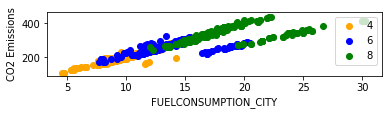

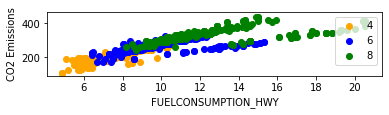

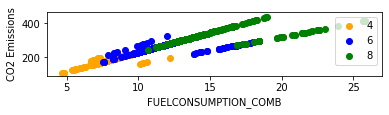

" As it happens, my hypothesis was not quite correct. My concern is that the model that we'd be making \nwill not account for the existence of the two distinct lines. The data will not be able to capture that...\nwe need some sort of 'piecewise' turn on/off value that can achieve this. i.e. if size + cylinders = x amount, \nthen change gradient to make more steep"

In [7]:
""" Here I wish to explore my hypothesis further, about the cylinders! 
I will recreate the same plots, but make sure that the color of the points reflects on the cylinders 
that there are """
print(df_pred['CYLINDERS'].value_counts()) #as it happens, based on this, there cars of many different cylinders, not
#just 6 8 10. Let's continue plotting to see what happens

cylinders = [4,6,8]
colors = ['orange','blue','green']
i = 1;
for cons_type in fuel_cons:
    plt.subplot(3,1,i)
    i+=1
    for index, cylinder in enumerate(cylinders):
        #plt.scatter(df_pred[cons_type],df_targ)
        plt.scatter(df[[cons_type]].loc[df['CYLINDERS'] == cylinder],df[['CO2EMISSIONS']].loc[df['CYLINDERS'] == cylinder],color = colors[index] )
    plt.legend(labels = cylinders, loc = 'upper right')

    plt.xlabel(cons_type)
    plt.ylabel('CO2 Emissions')
    plt.show()

""" As it happens, my hypothesis was not quite correct. My concern is that the model that we'd be making 
will not account for the existence of the two distinct lines. The data will not be able to capture that...
we need some sort of 'piecewise' turn on/off value that can achieve this. i.e. if size + cylinders = x amount, 
then change gradient to make more steep"""

## Further exploration

X    514
Z    434
E     92
D     27
Name: FUELTYPE, dtype: int64


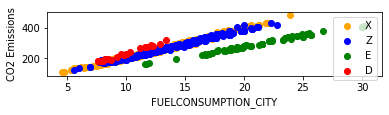

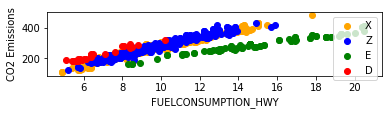

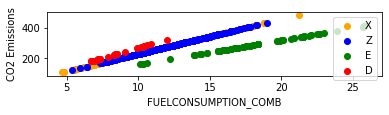

" Moving on: we can split the data set such that we have a dataset for fuel E, and one for the others, \nor alternatively: we may try to create a model that takes account for the difference between the fuels. \nSince we have a clear two line split, we can probably use a binary 'weight' to turn on/off an extra parameter\nthat affects the gradient solely?"

In [8]:
# other things that we might want to consider

print(df['FUELTYPE'].value_counts())

#the split that I'm thinking may actually be caused by the fuel type, let's experiment


fueltype = ['X','Z','E','D']
colors = ['orange','blue','green','red']
i = 1;
for cons_type in fuel_cons:
    plt.subplot(3,1,i)
    i+=1
    for index, fuel in enumerate(fueltype):
        #plt.scatter(df_pred[cons_type],df_targ)
        plt.scatter(df[[cons_type]].loc[df['FUELTYPE'] == fuel],df[['CO2EMISSIONS']].loc[df['FUELTYPE'] == fuel],color = colors[index] )
    plt.legend(labels = fueltype, loc = 'upper right')

    plt.xlabel(cons_type)
    plt.ylabel('CO2 Emissions')
    plt.show()
    
""" Nice! This was the key indeed. It seems like the thing that's causing the split is the fuel type
In fact visually we can see that the effect of fuel type is so large, that we can have 2 models: 
1 for fuels X,Z and D, and the other for fuel E. This way we can probably get very good regression 
results.

In hindsight: my hypothesis that cylinder type would be causing the divide between the two lines was poor.
since we are measuring CO2 emissions, the first thing that should come to mind is fuel type."""

""" Moving on: we can split the data set such that we have a dataset for fuel E, and one for the others, 
or alternatively: we may try to create a model that takes account for the difference between the fuels. 
Since we have a clear two line split, we can probably use a binary 'weight' to turn on/off an extra parameter
that affects the gradient solely?"""

In [18]:
#split data by fuel type

fuel_E = df.loc[df['FUELTYPE']=='E']
fuel_other = df.loc[df['FUELTYPE']!='E']
type(fuel_E

SyntaxError: unexpected EOF while parsing (<ipython-input-18-7c18f5b75fdb>, line 5)

## Modelling and model evaluation

In [36]:
# import modelling related modules
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split as tts

#import evaluation related modules
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score






In [40]:
"""This is for fuel_E"""
X = np.asanyarray(fuel_E[['ENGINESIZE','CYLINDERS','FUELCONSUMPTION_COMB']]) #X capital as it's multivariate
y = np.asanyarray(fuel_E[['CO2EMISSIONS']]) #still unsure what asanyarray does...?

x_train, x_test, y_train, y_test = tts(X , y,test_size = 0.2, random_state = 1) 
#remember random state is the seed

lm = LinearRegression() #make linear regression object
lm.fit(x_train,y_train)

y_hat = lm.predict(x_test)

#metrics:
print(r2_score(y_test,y_hat))
print(mse(y_test,y_hat))
#though these results are quite positive, it kind of makes sense since visually it appears that the line has very little error
#let's now try to make a model for the other fuels to see if we get such perfect data or not 
#(Note: we EXPECT NOT TO!)

0.9999774102447679
0.09169062755245223


In [41]:
""" Other fuels """

X = np.asanyarray(fuel_other[['ENGINESIZE','CYLINDERS','FUELCONSUMPTION_COMB']]) 
y = np.asanyarray(fuel_other[['CO2EMISSIONS']])

x_train, x_test, y_train, y_test = tts(X , y,test_size = 0.2, random_state = 1) 

lm = LinearRegression()
lm.fit(x_train,y_train)

y_hat = lm.predict(x_test)

#metrics:
print(r2_score(y_test,y_hat))
print(mse(y_test,y_hat))

#the result is still fairly good, once again agreeing with our visual inspection

0.9915387032688806
33.45712348517653


## Conclusion

The data clearly shows that fuel type is the main factor affecting the CO2 consumption of the cars. Visually we can see that it may even suffice to use Fuelcombustion as the only predictor variable, and that a multivariate analysis is not even required (thus saving computational time). The latter was only attempted for practice purposes.